In [2]:
# Dependencies and Setup
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import scipy.stats as st
from pprint import pprint
from scipy.stats import linregress

%matplotlib inline

In [3]:
# Store filepath in a variable
NBAdata = "../Output/MASTER_NBA_DATA.csv"
# Read our Data file with the pandas library
# Not every CSV requires an encoding, but be aware this can come up
NBAdata_df = pd.read_csv(NBAdata, encoding="ISO-8859-1")
NBAdata_df.head()

,GameID,Date,City,Country,Home Team,Away Team,Attendance,Home Score,Home 1st Q,Home FG%,Home 3pt%,Home FT%,Away Score,Away 1st Q,Away FG%,Away 3pt%,Away FT%
0,4c06f6af-980b-41b3-85c3-5975d8e03956,2018-10-17T00:00:00+00:00,Boston,USA,Celtics,76ers,18624,105,21,43.3,29.7,71.4,87,21,39.1,19.2,60.9
1,3594f3a2-86b8-4337-83d3-269c078c7f1f,2018-10-17T02:30:00+00:00,Oakland,USA,Warriors,Thunder,19596,108,31,44.2,26.9,94.4,100,23,36.3,27.0,64.9
2,24b19539-d496-460a-9e9b-2194d0fcc82a,2018-10-17T23:00:00+00:00,Detroit,USA,Pistons,Nets,20332,103,24,42.4,25.0,86.4,100,29,48.8,18.5,68.2
3,35a15ba5-77f8-45f5-91a6-79bbc3fbf989,2018-10-17T23:00:00+00:00,Charlotte,USA,Hornets,Bucks,17889,112,23,44.6,42.1,63.6,113,36,49.4,41.2,75.0
4,b83e3709-b996-4df3-b448-af91c5566187,2018-10-17T23:00:00+00:00,Indianapolis,USA,Pacers,Grizzlies,17923,111,27,56.6,38.5,53.8,83,16,29.8,34.5,82.1


In [14]:
# This code converts the provided Date format to unix for binning
seasondf = pd.DataFrame(NBAdata_df[['Date']])
seasondf['DateTime'] = pd.to_datetime(seasondf['Date'])
NBAdata_df['unix'] = seasondf.DateTime.astype(np.int64)//10**9

bins = [0, 1554854400, 9999999999]
group_names = ["2018-2019", "2019-2020"]

NBAdata_df["Season"] = pd.cut(NBAdata_df['unix'], bins, labels=group_names)

# This code calculates Total Games and Average Attendance per Season
seasongrpdf = NBAdata_df.groupby("Season")
guni = seasongrpdf["GameID"].nunique()
aat = seasongrpdf["Attendance"].mean()

# add the math
NBAStats = pd.DataFrame({'Total Games': guni, 'Average Attendance': aat})
NBAStats

,Total Games,Average Attendance
Season,,
2018-2019,1217,17870.339243
2019-2020,985,17797.486294


In [17]:
# Determine if there are any potential outliers in the average occupancy in California
quartiles = NBAdata_df['Attendance'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of occupancy is: {lowerq}")
print(f"The upper quartile of occupancy is: {upperq}")
print(f"The interquartile range of occupancy is: {iqr}")
print(f"The the median of occupancy is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of occupancy is: 16718.0
The upper quartile of occupancy is: 19432.0
The interquartile range of occupancy is: 2714.0
The the median of occupancy is: 18203.0 
Values below 12647.0 could be outliers.
Values above 23503.0 could be outliers.


In [19]:
# Create the bins in which Data will be held
# Bins are 0, 59.9, 69.9, 79.9, 89.9, 100.   
bins = [0, 16394, 18203, 19432, 23989]

# Create the names for the five bins
group_names = ["1Q Atten", "2Q Atten", "3Q Atten", "4Q Atten"]

# Slice the data and place it into bins
pd.cut(NBAdata_df["Attendance"], bins, labels=group_names).head()
# Place the data series into a new column inside of the DataFrame
NBAdata_df["Attendance Group"] = pd.cut(NBAdata_df["Attendance"], bins, labels=group_names)

In [21]:
# Create a GroupBy object based upon "View Group"
NBA_group = NBAdata_df.groupby("Attendance Group")

# Get the average of each column within the GroupBy object
NBA_group[["Home Score", "Home 1st Q", "Home FG%","Home 3pt%","Home FT%","Away Score","Away 1st Q","Away FG%","Away 3pt%","Away FT%" ]].mean()

NBA_group_df = pd.DataFrame(NBA_group[["Home Score", "Home 1st Q", "Home FG%","Home 3pt%","Home FT%","Away Score","Away 1st Q","Away FG%","Away 3pt%","Away FT%" ]].mean())
NBA_group_df

,Home Score,Home 1st Q,Home FG%,Home 3pt%,Home FT%,Away Score,Away 1st Q,Away FG%,Away 3pt%,Away FT%
Attendance Group,,,,,,,,,,
1Q Atten,111.826087,27.776398,46.476190,35.625259,76.424638,111.122153,27.714286,46.267288,35.600828,77.164182
2Q Atten,113.397321,28.318452,46.514137,35.650446,75.930357,110.910714,27.989583,45.603571,35.293601,76.718452
3Q Atten,111.797468,28.110307,46.615732,36.326582,77.390778,108.417722,26.974684,45.206329,34.743761,76.644123
4Q Atten,112.886100,28.805019,46.869884,36.227413,77.179730,109.457529,27.324324,45.308301,35.092664,76.711004


Text(0.5, 0, 'Attendance Quartiles')

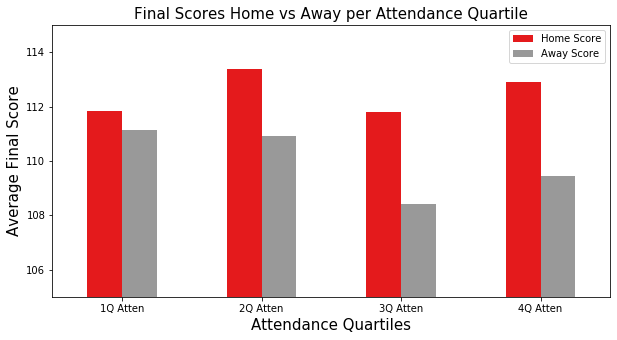

In [23]:
bardf = pd.DataFrame(NBA_group_df[['Home Score', 'Away Score']])

barplot = bardf.plot(kind='bar', figsize=(10,5), rot=0, ylim=[105,115], colormap='Set1')
barplot.set_title("Final Scores Home vs Away per Attendance Quartile", fontsize=15)
barplot.set_ylabel("Average Final Score", fontsize=15)
barplot.set_xlabel("Attendance Quartiles", fontsize=15)


Text(0.5, 0, 'Attendance Quartiles')

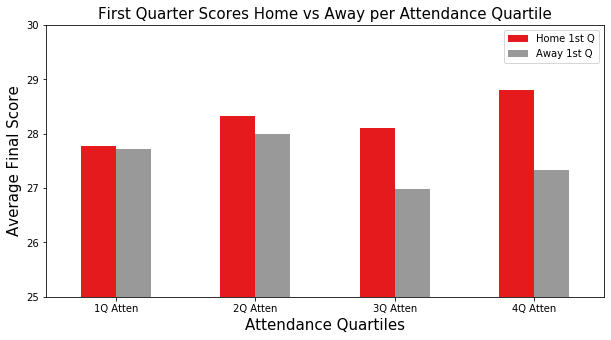

In [32]:
bardf = pd.DataFrame(NBA_group_df[['Home 1st Q', 'Away 1st Q']])

barplot = bardf.plot(kind='bar', figsize=(10,5), rot=0, ylim=[25,30], colormap='Set1')
barplot.set_title("First Quarter Scores Home vs Away per Attendance Quartile", fontsize=15)
barplot.set_ylabel("Average Final Score", fontsize=15)
barplot.set_xlabel("Attendance Quartiles", fontsize=15)

[Text(0, 0, 'First Quartile'),
 Text(0, 0, '2nd Quartile'),
 Text(0, 0, '3rd Quartile'),
 Text(0, 0, '4th Quartile')]

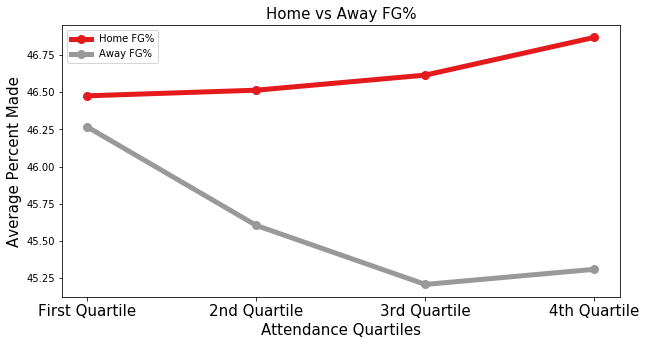

In [29]:
fgdf = pd.DataFrame(NBA_group_df[["Home FG%","Away FG%"]])
fgdf = fgdf.reset_index()
xt = ['First Quartile', '2nd Quartile','3rd Quartile','4th Quartile']


fgplot = fgdf.plot(kind='line', marker='o', markersize=8, figsize=(10,5), 
                   rot=0, colormap='Set1', linewidth=5.0)
fgplot.set_title("Home vs Away FG%", fontsize=15)
fgplot.set_ylabel("Average Percent Made", fontsize=15)
fgplot.set_xlabel("Attendance Quartiles", fontsize=15)
fgplot.set_xticks(fgdf.index)
fgplot.set_xticklabels(xt, rotation=0, fontsize=15)

[Text(0, 0, 'First Quartile'),
 Text(0, 0, '2nd Quartile'),
 Text(0, 0, '3rd Quartile'),
 Text(0, 0, '4th Quartile')]

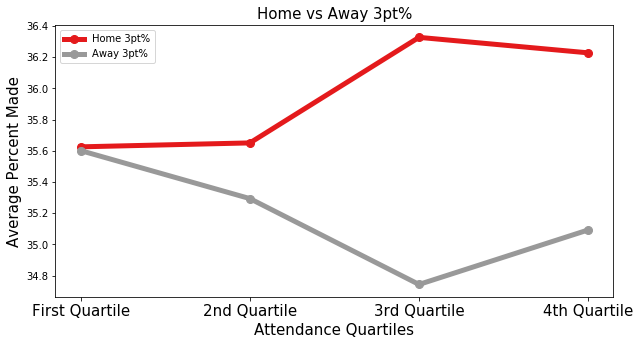

In [36]:
tpdf = pd.DataFrame(NBA_group_df[["Home 3pt%","Away 3pt%"]])
tpdf = tpdf.reset_index()
xt = ['First Quartile', '2nd Quartile','3rd Quartile','4th Quartile']


tpplot = tpdf.plot(kind='line', marker='o', markersize=8, figsize=(10,5), 
                   rot=0, colormap='Set1', linewidth=5.0)
tpplot.set_title("Home vs Away 3pt%", fontsize=15)
tpplot.set_ylabel("Average Percent Made", fontsize=15)
tpplot.set_xlabel("Attendance Quartiles", fontsize=15)
tpplot.set_xticks(tpdf.index)
tpplot.set_xticklabels(xt, rotation=0, fontsize=15)

[Text(0, 0, 'First Quartile'),
 Text(0, 0, '2nd Quartile'),
 Text(0, 0, '3rd Quartile'),
 Text(0, 0, '4th Quartile')]

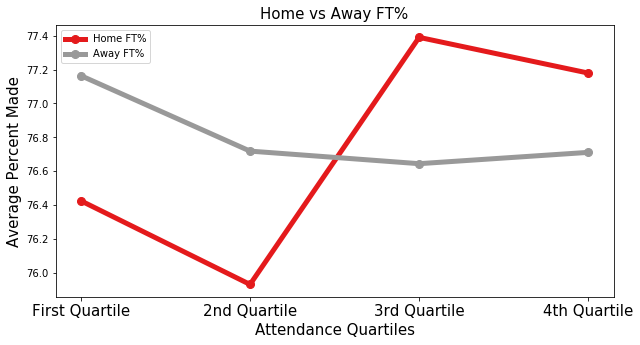

In [33]:
ftdf = pd.DataFrame(NBA_group_df[["Home FT%","Away FT%"]])
ftdf = ftdf.reset_index()
xt = ['First Quartile', '2nd Quartile','3rd Quartile','4th Quartile']


ftplot = ftdf.plot(kind='line', marker='o', markersize=8, figsize=(10,5), 
                   rot=0, colormap='Set1', linewidth=5.0)
ftplot.set_title("Home vs Away FT%", fontsize=15)
ftplot.set_ylabel("Average Percent Made", fontsize=15)
ftplot.set_xlabel("Attendance Quartiles", fontsize=15)
ftplot.set_xticks(tpdf.index)
ftplot.set_xticklabels(xt, rotation=0, fontsize=15)